Loading dataset from ../data/raw/complaints.csv...
Initial shape: (9609797, 18)


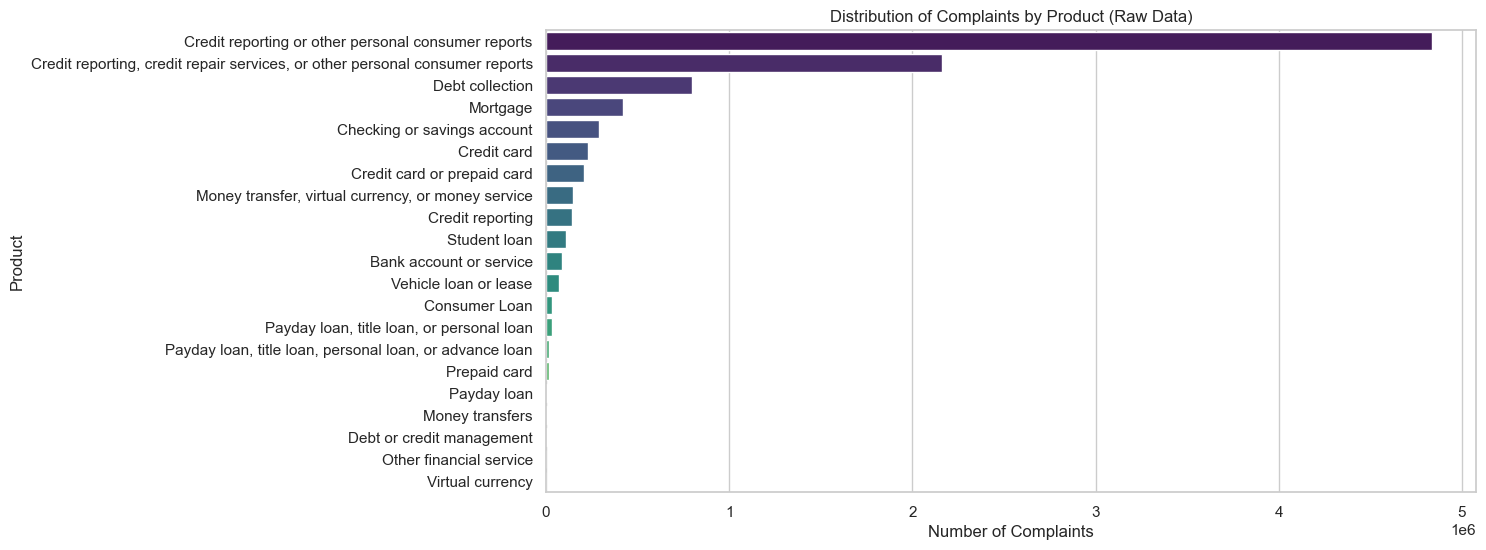

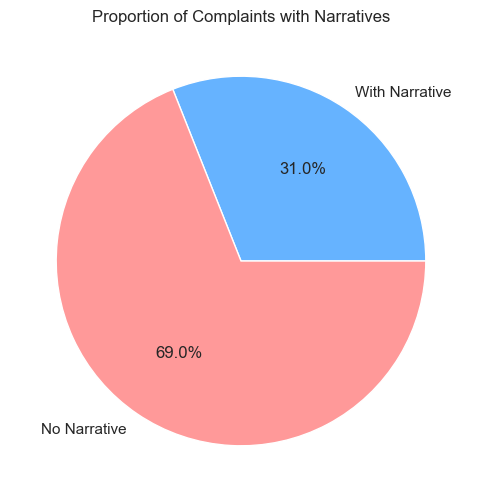

Complaints with narratives: 2980756
Complaints without narratives: 6629041
Dropping rows with missing narratives...
Shape after filtering for Products: (478911, 19)
Unified_Product
Credit Card        197126
Savings Account    155204
Money Transfers     98701
Personal Loan       27880
Name: count, dtype: int64
Cleaning text narratives (this may take a moment)...


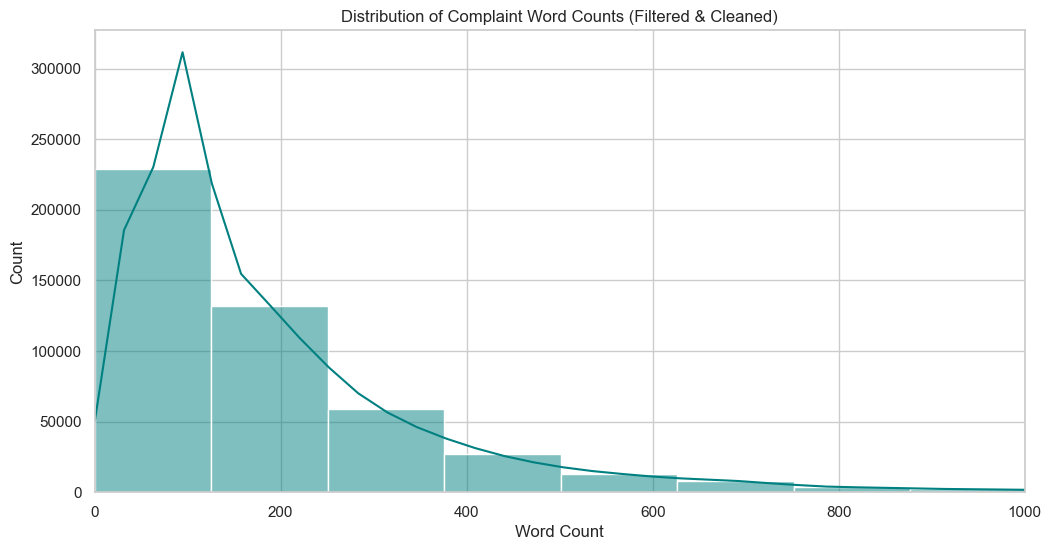

count    478911.000000
mean        198.940171
std         217.633778
min           0.000000
25%          80.000000
50%         133.000000
75%         247.000000
max        6263.000000
Name: word_count, dtype: float64
Number of complaints with < 10 words: 2468
Success! Processed data saved to ../data/processed/filtered_complaints.csv
Final dataset size: (476443, 21)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Set plot style
sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', 100)

# ==========================================
# 1. Load Data
# ==========================================
DATA_PATH = '../data/raw/complaints.csv' # Adjust path if necessary
OUTPUT_PATH = '../data/processed/filtered_complaints.csv'

print(f"Loading dataset from {DATA_PATH}...")
# Depending on the file size, you might need low_memory=False or specify dtypes
df = pd.read_csv(DATA_PATH, low_memory=False)

print(f"Initial shape: {df.shape}")

# ==========================================
# 2. Initial EDA (Before Filtering)
# ==========================================

# 2.1 Distribution of Products
plt.figure(figsize=(12, 6))
product_counts = df['Product'].value_counts()
sns.barplot(y=product_counts.index, x=product_counts.values, hue=product_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Complaints by Product (Raw Data)')
plt.xlabel('Number of Complaints')
plt.show()

# 2.2 Complaints with vs without Narratives
# The column is usually 'Consumer complaint narrative'
has_narrative = df['Consumer complaint narrative'].notna().sum()
no_narrative = df['Consumer complaint narrative'].isna().sum()

plt.figure(figsize=(6, 6))
plt.pie([has_narrative, no_narrative], labels=['With Narrative', 'No Narrative'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title('Proportion of Complaints with Narratives')
plt.show()

print(f"Complaints with narratives: {has_narrative}")
print(f"Complaints without narratives: {no_narrative}")

# ==========================================
# 3. Filtering and Preprocessing
# ==========================================

# 3.1 Drop rows without narratives
print("Dropping rows with missing narratives...")
df_clean = df.dropna(subset=['Consumer complaint narrative']).copy()

# 3.2 Standardize Product Categories
# The CFPB changes product names over time. We need to map them to the 4 categories requested.
# Request: Credit Cards, Personal Loans, Savings Accounts, Money Transfers

def map_product_category(product_name):
    product_name = str(product_name).lower()
    
    if 'credit card' in product_name or 'prepaid card' in product_name:
        return 'Credit Card'
    elif 'checking' in product_name or 'savings' in product_name or 'bank account' in product_name:
        return 'Savings Account'
    elif 'money transfer' in product_name or 'virtual currency' in product_name:
        return 'Money Transfers'
    elif 'personal loan' in product_name or 'payday loan' in product_name or 'title loan' in product_name:
        return 'Personal Loan'
    else:
        return 'Other'

df_clean['Unified_Product'] = df_clean['Product'].apply(map_product_category)

# Filter for only the 4 target categories
target_categories = ['Credit Card', 'Savings Account', 'Money Transfers', 'Personal Loan']
df_filtered = df_clean[df_clean['Unified_Product'].isin(target_categories)].copy()

print(f"Shape after filtering for Products: {df_filtered.shape}")
print(df_filtered['Unified_Product'].value_counts())

# 3.3 Text Cleaning Function
def clean_narrative(text):
    if not isinstance(text, str):
        return ""
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove CFPB redaction markers (The dataset uses 'XXXX' to hide personal info)
    text = re.sub(r'x{2,}', '', text) 
    
    # 3. Remove boilerplate (e.g., "I am writing to file a complaint") using basic heuristics
    # Note: Deep cleaning requires more advanced NLP, but this removes common noise
    text = re.sub(r'xxxx', '', text) 
    
    # 4. Remove special characters and newlines, keeping punctuation
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip() # Collapse multiple spaces
    
    return text

print("Cleaning text narratives (this may take a moment)...")
df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_narrative)

# ==========================================
# 4. Post-Processing Analysis
# ==========================================

# 4.1 Narrative Length Analysis (Word Count)
df_filtered['word_count'] = df_filtered['cleaned_narrative'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(df_filtered['word_count'], bins=50, kde=True, color='teal')
plt.title('Distribution of Complaint Word Counts (Filtered & Cleaned)')
plt.xlabel('Word Count')
plt.xlim(0, 1000) # Limiting x-axis to see the bulk of data
plt.show()

# Calculate stats
print(df_filtered['word_count'].describe())

# Check for very short complaints (noise)
short_complaints = df_filtered[df_filtered['word_count'] < 10]
print(f"Number of complaints with < 10 words: {len(short_complaints)}")

# Optional: Remove extremely short narratives (less than 10 words) as they lack context for RAG
df_final = df_filtered[df_filtered['word_count'] >= 10].copy()

# ==========================================
# 5. Save Data
# ==========================================

# Select relevant columns for the RAG pipeline
cols_to_keep = [
    'Complaint ID', 
    'Date received', 
    'Unified_Product',  # The mapped category
    'Product',          # Original category (good for metadata)
    'Issue', 
    'Sub-issue',
    'Company', 
    'State', 
    'Consumer complaint narrative', # Original
    'cleaned_narrative' # Processed
]

# Ensure output directory exists
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

df_final[cols_to_keep].to_csv(OUTPUT_PATH, index=False)
print(f"Success! Processed data saved to {OUTPUT_PATH}")
print(f"Final dataset size: {df_final.shape}")